In [1]:
''' HELPERS '''
#print(dir(essentia.standard))
#print(help(es.MonoLoader))

' HELPERS '

In [2]:
import essentia
print(essentia.__version__)
print(essentia.__file__)
import essentia.standard as es

# let's have a look at what is in there
#print(dir(essentia.standard))

import json
import matplotlib.pyplot as plt
import numpy as np
import cv2

import utils.util as util
import moviepy.editor as mp

2.1-beta6-dev
/usr/local/lib/python3.8/site-packages/essentia/__init__.py


2023-04-04 22:43:18.252422: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
test_mp4_paths,test_mp4_labels,test_aac_paths,test_aac_labels = util.load_xdv_test(util.SERVER_TEST_AUD_ORIG_PATH)

path = test_mp4_paths[10]
print("PATH",path)
print(util.get_total_time(path))

# Extract the audio from the video
audio = mp.AudioFileClip(filename=path)#.subclip(t_start=0,t_end=2)#.fx(mp.afx.audio_normalize)
audio_total_array = audio.to_soundarray(fps=22050)
audio_total_array_mono = np.mean(audio_total_array, axis=1)
audio_total_array_mono_single = audio_total_array_mono.astype(np.float32)

audio2predict = audio_total_array_mono_single

acc_path /raid/DATASETS/anomaly/XD_Violence/aud/testing/original
PATH /raid/DATASETS/anomaly/XD_Violence/testing_copy/Bad.Boys.II.2003__#00-06-42_00-10-00_label_B2-G-0.mp4
198.04166666666666


In [4]:
# Loading the model
graph_filename = "/raid/DATASETS/.zuble/vigia/zuwav/fsd-sinet-essentia/models/fsd-sinet-vgg41-tlpf-1.pb"
model = es.TensorflowPredictFSDSINet(graphFilename=graph_filename)

# Read the metadata
metadata_file = "/raid/DATASETS/.zuble/vigia/zuwav/fsd-sinet-essentia/models/fsd-sinet-vgg41-tlpf-1.json"
metadata = json.load(open(metadata_file, "r"))
labels = metadata["classes"]

predictions = model(audio2predict)

[   INFO   ] TensorflowPredict: Successfully loaded graph file: `/raid/DATASETS/.zuble/vigia/zuwav/fsd-sinet-essentia/models/fsd-sinet-vgg41-tlpf-1.pb`
2023-04-04 22:43:21.647473: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2198820000 Hz


(200,) (200,)


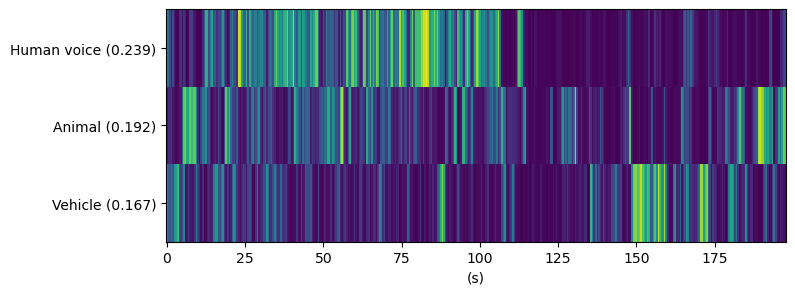

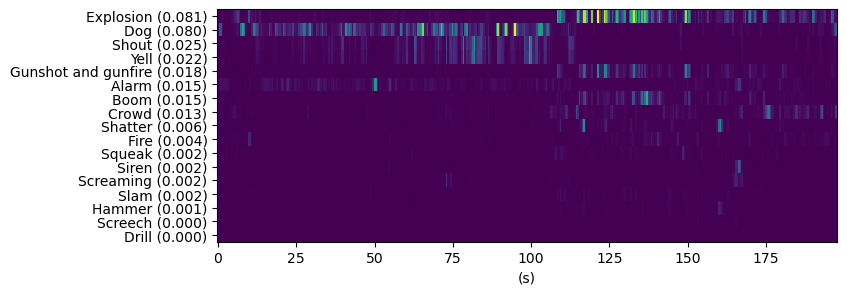

In [7]:
printt=False;plott=False;save_plot=False


anom_labels = ["Alarm","Boom","Crowd","Dog","Drill","Explosion","Fire","Gunshot and gunfire","Hammer","Screaming","Screech",\
                            "Shatter","Shout","Siren","Slam","Squeak","Yell"]
anom_labels_i = [4,18,51,59,65,72,78,92,94,145,146,147,148,152,154,161,198]


def plot_predictions(top_preds, top_labels_w_av,top_labels_with_av):
    # Generate plots and improve formatting
    matfig = plt.figure(figsize=(8, 3))
    plt.matshow(top_preds, fignum=matfig.number, aspect="auto")

    plt.yticks(np.arange(len(top_labels_w_av)), top_labels_with_av)
    locs, _ = plt.xticks()
    ticks = np.array(locs // 2).astype("int")
    plt.xticks(locs[1: -1], ticks[1: -1])
    plt.tick_params(bottom=True, top=False, labelbottom=True, labeltop=False)
    plt.xlabel("(s)")

    if save_plot : plt.savefig("activations.png", bbox_inches='tight')

def process_rslt_all(predictions):
    def top_from_average(data, top_n):
        av = np.mean(data, axis=0)
        sorting = np.argsort(av)[::-1]
        print(np.shape(av),np.shape(sorting))
        return sorting[:top_n], [av[i] for i in sorting] ,av

    top_labels_i, averages_sorted , averages = top_from_average(predictions,3)
    top_labels = [labels[i] for i in top_labels_i]
    top_labels_with_av = [f"{label} ({av:.3f})" for label, av in zip(top_labels, averages_sorted)]
    top_predictions = np.array([predictions[:,i] for i in top_labels_i])
    plot_predictions(top_predictions, top_labels_with_av,top_labels_with_av)
    
def process_rslt_anom(predictions):
    def top_from_anomaly(data):
        av = np.mean(data, axis=0)
        sorting = np.argsort(av)[::-1]
        sorting_anom = [x for x in sorting if x in anom_labels_i]
        return sorting_anom,[av[i] for i in sorting_anom]

    top_labels_anom_i, averages_anom_sorted = top_from_anomaly(predictions)
    top_labels_anom = [labels[i] for i in top_labels_anom_i]
    top_labels_anom_with_av = [f"{label} ({av:.3f})" for label, av in zip(top_labels_anom, averages_anom_sorted)]
    top_predictions_anom = np.array([predictions[:,i] for i in top_labels_anom_i])
    plot_predictions(top_predictions_anom, top_labels_anom_with_av,top_labels_anom_with_av)

process_rslt_all(predictions)   
process_rslt_anom(predictions)   

In [6]:
if printt: 
    for label, probability in zip(metadata['classes'], predictions.mean(axis=0)):
        print(f'{label}: {100 * probability:.1f}%') 
    print(top_labels)
    print(top_labels_with_av)

if plott: plot_predictions(top_predictions, top_labels_with_av)
